# This Notebook is for EDA and Clean-up of the provided data set for the Machine Learning course
## TODO List (in addition to in-line):
- Encode additional variables for use
    - Determine how to encode diags -- Don't know what to do yet
- Implement Class Imbalance Procedures
- Implement N.N
- Implement gradient boosting
- Fix PCA

## Set Up

In [251]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SkLearn  Data Prep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce


# SkLearn Measurement Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [252]:
# Get Main Data
path = os.getcwd()
path = path +'\\medical_data\\'
file = 'data.csv'

mainData = pd.read_csv(path+file)
mainData.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2,189899286,729,Caucasian,Female,[80-90),NaN,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
3,64331490,774,Caucasian,Female,[80-90),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
4,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [253]:
# Get Admission Type Look-Up
file = 'id_lookup.csv'
admissionTypeLookUp = pd.read_csv(path+file)
admissionTypeLookUp = admissionTypeLookUp.iloc[:8]
admissionTypeLookUp['admission_type_id'] = admissionTypeLookUp['admission_type_id'].astype(int)
admissionTypeLookUp

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [254]:
# Set Aside Copy of DF for Experiments
expData = mainData

## Re-Usable Functions

In [255]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per","Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [256]:
# Takes a DF, list of variable,and an order and returns a DF w/ ordinal encoding
def OrdinalEncoderFunc (df,listOfVars,order):
    df=df
    order=order
    enc = OrdinalEncoder(categories=[order])
    for col in listOfVars:
        col=col
        df[col] = enc.fit_transform(df[[col]])
    return df

In [257]:
def target_encoder(df, var, var1): #var1 needs to be a target (numerical not categorical)
    tenc = ce.TargetEncoder()
    df[var] = (tenc.fit_transform(df[[var]], df[[var1]]))
    return df

In [258]:
# Custom Clean-Up Function For This Dataset -- 1
def EncodeResponse (df):
    df=df
    # Execute Encoding
    dummyTemp = pd.get_dummies(df['readmitted'],prefix='readmitted_')
    df = df.join(dummyTemp)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
    df = df.drop(columns=['readmitted']) # Drop Old Readmitted Column
    df = df.rename(columns={'readmitted__NO': 'readmitted'}) # Rename encoded column
    df = df.dropna(subset=['readmitted']) # drop puzzling 1 nan value
    df['readmitted'] = df['readmitted'].map({0:1, 1:0}) # reverse encoding to make logical
    return df


In [259]:
# Custom Clean-Up Function For This Dataset -- 2
# TODO: Clean-up for demographic Vars (age, gender, race)

def AdditionalClean (df):
    df=df
    #1 - Null Clean-Up2 -- Fillna's for variables with nulls that have value to keep
    df['race'] = df['race'].fillna('Unknown')
    #2 - Race to Dummy Vars
    dummyTemp = pd.get_dummies(df['race'],prefix='race_')
    df = df.join(dummyTemp)
    df = df.drop(columns=['race'])
    #2 - Encode Gender
    number = LabelEncoder()
    df['gender'] = number.fit_transform(df['gender']) # F -> 1, M -> 0, Unknown -> 2
    #3 - Encode diabetesMed
    df['diabetesMed'] = number.fit_transform(df['diabetesMed']) # Yes -> 1, No -> 0
    #4 Custom Encode 1 -  A1Cresult
    mapping_a1 = {'None':0,'Norm':0,'>7':1,'>8':2}
    df['A1Cresult'] = df['A1Cresult'].map(mapping_a1)
    #5 Custom Encode 2 -  max_glu_serum
    mapping_glu = {'None':0,'Norm':0,'>200':1,'>300':2}
    df['max_glu_serum'] = df['max_glu_serum'].map(mapping_glu)
    #6 Custom Encode 3 - change
    mapping_change = {'No':0,'Ch':1,}
    df['change'] = df['change'].map(mapping_change)
    #7 - Convert Age Buckets to Single Numeric
    df['age'] = df['age'].str[1:3]
    df['age'] = df['age'].str.rstrip('-')
    df['age'] = df['age'].astype('int')
    df = df.rename(columns={'age': 'age_10yrStart'})
    return df

In [260]:
# Main Clean DF Function -- Wraps Clean-Up Steps into one function so I can run on multiple versions of a DF
## Does not include steps for cleaning response variable.

def Clean_DF_Wrapper (df_to_clean,ordEncode_Vars,ordEncode_order,medCols):

    # Null Clean-Up1 -- Drop Columns with high % of nulls, that aren't worth filling
    df_to_clean = df_to_clean.drop(columns=['weight','medical_specialty','payer_code'])

    # Diag Clean-Up
    ## If diag_2 is null, then use diag_3.  If diag_1 is null, then use diag_2
    ## Solves all but 1 null Diag1, which is dropped
    ## TODO: Determine how to drop value from column that I pull from.
    df_to_clean['diag_2'] = df_to_clean['diag_2'].fillna(df_to_clean['diag_3'])
    df_to_clean['diag_1'] = df_to_clean['diag_1'].fillna(df_to_clean['diag_2'])
    df_to_clean = df_to_clean.dropna(subset=['diag_1'])

    # Remove Deceased Patients
    ## Note: The research question is about predicting what patients will be re-admitted.
    ## In order to not skew the results, patients who died while admitted should be removed from the prediction
    ## Note: I only removed cases that explicity said the patient expired. not hospice patients (13,14)
    expCodes = ['11','19','20','21']
    df_to_clean = df_to_clean[~df_to_clean['discharge_disposition_id'].isin(expCodes)]

    # Call OrdinalEncoder Function
    df_to_clean  = OrdinalEncoderFunc(df_to_clean,ordEncode_Vars,ordEncode_order)

    # Add Variable For Number of Medications
    df_to_clean['num_of_meds'] = df_to_clean[medCols].ne(0).sum(axis=1)

    # Add Variable for Medication Level Up Or Down
    ## In the Medication columns 1 signifies that dosage decreased, 3 signifies that dosage increased
    ## This counts the number of 1 and coverts to a negative, then the adds the number of 3
    ## Result indicates the net level of medication change
    df_to_clean['med_level_direction'] = ((df_to_clean[medCols] == 1).sum(axis=1)*-1) + \
                                  (df_to_clean[medCols] == 3).sum(axis=1)

    # Call Function w/ all custom clean-up steps
    df_to_clean = AdditionalClean(df_to_clean)

    return df_to_clean

In [261]:
# Clean DF Function For Response -- Wraps Steps into one function so I can run on multiple versions of a DF
## Seems strange that it only calls another function, wanted structure in case I added other steps

def Clean_ResponseVar (df_to_clean):
    df_to_clean = EncodeResponse(df_to_clean)
    return df_to_clean


In [262]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    df=df
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [263]:
# Takes a model, and test sets and returns and ROC Curve w/ AUC value

def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve for RF classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt


In [264]:
# Takes a model and various split sets and returns a CM plot w/ Accuracy

def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [265]:
# Takes test and predicted sets and returns precision/recall metrics

def precisionRecall (y_test, y_pred):
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    return precision, recall, f1

In [266]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=PredictorVar)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [267]:
# Takes a DF and returns an elbow plot for KMeans in order to determine the proper K Value
## Think of as KMeans Pre-Analysis

def KMeansElbowPlot(df):
    # Elbow Method -- To Set K Range
    k_rng = range(1,10)
    # sum of square error
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(df)
        sse.append(km.inertia_)
    # Elbow Plot w / SSE
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.plot(k_rng,sse)
    return plt

In [268]:
# Takes a DF, list of Predictor Vars, and Response Var and returns an elbow plot to determine optimal P.C.'s

def PCA_PreProcess_Elbow(df,PredictorVar,ResponseVar):
    # PCA -- CV
    upper = len(PredictorVar)
    row =[]
    pca_Result = pd.DataFrame(columns = ["Number_Variables","MSE",'RMSE',"Variance_Explained"])
    kf = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)
    # Function Call To prep train/test
    for i in range(upper):
        x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar[:i+1], ResponseVar)
        pca = PCA()
        x = pca.fit_transform(scale(x_test))
        regr = LinearRegression()
        regr.fit(x_train, y_train)
        score = -1*model_selection.cross_val_score(regr, x_test, y_test, cv=kf,
                                               scoring='neg_mean_squared_error').mean()
        varExplained = 1-(pca.explained_variance_ratio_[i])
        RMSE = np.sqrt(score)
        row = [i,score,RMSE,varExplained]
        df_length = len(pca_Result)
        pca_Result.loc[df_length] = row
    # PCA -- plot
    sns.set_style("whitegrid")
    sns.set(rc = {'figure.figsize':(5,5)})
    fig, (ax1,ax2) = plt.subplots(ncols=2,sharex=True, sharey=False, figsize=(15,9))
    sns.lineplot(
        data=pca_Result, ax=ax1,
        x="Number_Variables", y="MSE",
        marker="o", dashes=False)
    sns.lineplot(
        data=pca_Result, ax=ax2,
        x="Number_Variables", y="Variance_Explained",
        marker="o", dashes=False)
    return plt

In [269]:
# Run PCA on a given set after determined optimal number of features (m) w/ the Pre-Process Function.

def PCA_Actual(df,PCA_relevant_features,numFeatures):
    # Make a temp set w/ just PCA_PredictorVars
    tempSet = df[PCA_relevant_features]
    # PCA -- Run Actual on Set w/ Num Features Defined On Temp Set -- Produce Array
    pca_BestM = PCA(n_components=numFeatures, random_state=1)
    X_scaled = scale(tempSet)
    pca_BestM.fit(X_scaled)
    X_pca_bestM = pca_BestM.transform(X_scaled)
    # Convert Array into DF
    PC_Cols = []
    for i in range(numFeatures):
        num=str(i+1)
        PC_Cols.append("PC"+num)
    PCA_ResultsDF = pd.DataFrame(X_pca_bestM, columns=PC_Cols)
    #df = df.reset_index()
    #df = df.join(PCA_ResultsDF)
    df = pd.merge(df,PCA_ResultsDF, left_index=True, right_index=True)
    #print(len(df))
    # Drop PredictorVars -- replace w/ P.C
    df = df.drop(columns=PCA_relevant_features)
    # reset new Predictor Var List
    PredictorVar = df.columns.values.tolist()
    return df, PredictorVar

## General EDA

In [270]:
# Data Shape
print(f"Data shape:",mainData.shape)

Data shape: (71518, 50)


In [271]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      69570 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    2853 non-null   object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                40475 non-null  object
 11  medical_specialty         37041 non-null  object
 12  num_lab_procedures        71518 non-null  int64 
 13  num_procedures            71518 non-null  int64 
 14  num_medications       

In [272]:
# Describe
mainData.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,7.151800e+04,7.151800e+04,69570,71518,71518,2853,71518.000000,71518.000000,71518.000000,71518.00000,...,71518,71518,71518,71518,71518,71518,71518,71518,71518,71518
unique,NaN,NaN,5,3,10,9,NaN,NaN,NaN,NaN,...,1,4,4,2,1,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,53491,38025,18210,1195,NaN,NaN,NaN,NaN,...,71518,34921,71016,71511,71518,71516,71517,39494,54319,42985
mean,1.568156e+08,5.505160e+07,NaN,NaN,NaN,NaN,2.100254,3.593235,5.657457,4.28913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.003769e+08,3.947573e+07,NaN,NaN,NaN,NaN,1.508301,5.269771,4.162580,2.94921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.145807e+07,2.337577e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.440574e+08,4.816680e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,3.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.155513e+08,8.752222e+07,NaN,NaN,NaN,NaN,3.000000,3.000000,7.000000,6.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
numericFeatures = mainData.select_dtypes(include= np.number)
numericFeatures = numericFeatures.drop(columns=['encounter_id','patient_nbr'])
numericFeatures.nunique()

admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          116
num_procedures                7
num_medications              75
number_outpatient            33
number_emergency             18
number_inpatient             13
number_diagnoses             16
dtype: int64

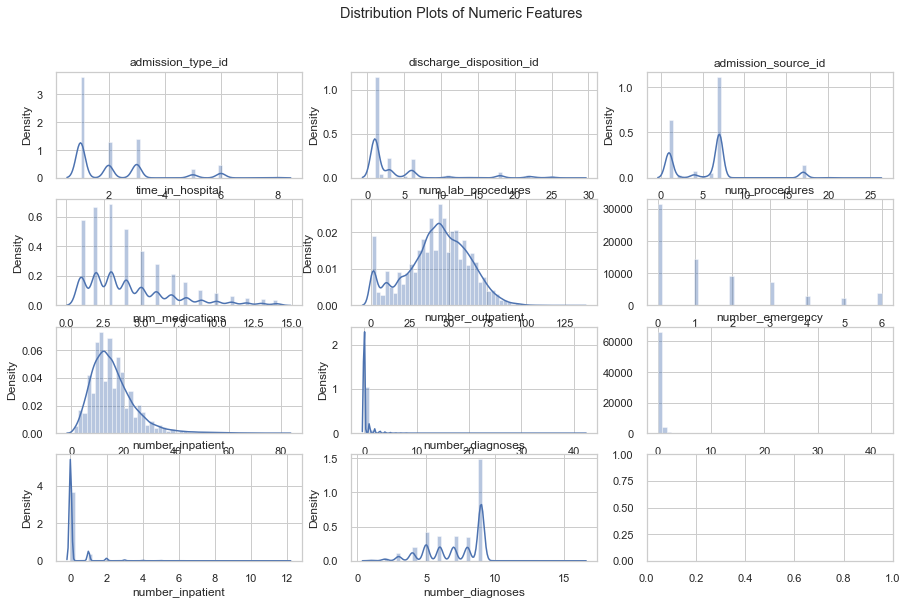

In [274]:
# Distribution Plots

fig, axes = plt.subplots(4,3, sharex=False, sharey=False, figsize=(15,9))
fig.suptitle('Distribution Plots of Numeric Features')

sns.distplot(numericFeatures['admission_type_id'], ax=axes[0,0], kde=True).set(title='admission_type_id')
sns.distplot(numericFeatures['discharge_disposition_id'], ax=axes[0,1], kde=True).set(title='discharge_disposition_id')
sns.distplot(numericFeatures['admission_source_id'], ax=axes[0,2], kde=True).set(title='admission_source_id')
sns.distplot(numericFeatures['time_in_hospital'], ax=axes[1,0], kde=True).set(title='time_in_hospital')
sns.distplot(numericFeatures['num_lab_procedures'], ax=axes[1,1], kde=True).set(title='num_lab_procedures')
sns.distplot(numericFeatures['num_procedures'], ax=axes[1,2], kde=False).set(title='num_procedures')
sns.distplot(numericFeatures['num_medications'], ax=axes[2,0], kde=True).set(title='num_medications')
sns.distplot(numericFeatures['number_outpatient'], ax=axes[2,1], kde=True).set(title='number_outpatient')
sns.distplot(numericFeatures['number_emergency'], ax=axes[2,2], kde=False).set(title='number_emergency')
sns.distplot(numericFeatures['number_inpatient'], ax=axes[3,0], kde=True).set(title='number_inpatient')
sns.distplot(numericFeatures['number_diagnoses'], ax=axes[3,1], kde=True).set(title='number_diagnoses')

plt.show()

In [275]:
# sns.pairplot(numericFeatures)

## General Data Clean-Up


In [276]:
# Print Null Summary
nullSummary = nullAnalysis(mainData)
nullSummary

Count of Variables: 50
Count of Variables without nulls: 43
Count of Variables with null : 7


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
5,weight,71518,68665,96.011,9,object
11,medical_specialty,71518,34477,48.207,70,object
10,payer_code,71518,31043,43.406,17,object
2,race,71518,1948,2.724,5,object
20,diag_3,71518,1225,1.713,758,object
19,diag_2,71518,294,0.411,725,object
18,diag_1,71518,11,0.015,696,object


In [277]:
# Specify Medications for Encoding
medCols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone']

# Set Function Params
df_to_clean = mainData
ordEncode_Vars = medCols
ordEncode_order = ['No','Down','Steady','Up']

cleanDF = Clean_DF_Wrapper(df_to_clean,ordEncode_Vars,ordEncode_order,medCols)
cleanDF = Clean_ResponseVar(cleanDF)
cleanDF.sample(5)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
50589,362511356,84361509,0,80,2,1,1,1,52,4,...,0,0,0,1,0,0,0,0,1,1
41048,273024054,60225642,0,30,3,1,1,5,52,0,...,0,0,0,1,0,0,0,0,0,0
2234,40064010,940923,0,70,3,18,1,3,39,3,...,0,1,0,0,0,0,0,0,0,0
4705,78541440,2586699,1,70,1,1,7,5,38,3,...,-2,0,0,1,0,0,0,0,0,0
3760,103531878,1814130,0,50,1,1,6,2,60,1,...,0,0,0,1,0,0,0,0,0,0


In [278]:
# Re-Run Null Summary
nullSummary = nullAnalysis(cleanDF)
nullSummary

Count of Variables: 56
Count of Variables without nulls: 54
Count of Variables with null : 2


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
16,diag_3,70433,1224,1.738,757,object
15,diag_2,70433,243,0.345,724,object


In [279]:
# Diag Encoders
target_encoder(cleanDF,'diag_1', 'readmitted')
target_encoder(cleanDF,'diag_2', 'readmitted')
target_encoder(cleanDF,'diag_3', 'readmitted')
cleanDF

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
0,24437208,135,0,50,2,1,1,8,77,6,...,-1,0,0,1,0,0,0,1,0,1
1,29758806,378,0,50,3,1,1,2,49,1,...,0,0,0,1,0,0,0,0,0,0
2,189899286,729,0,80,1,3,7,4,68,2,...,0,0,0,1,0,0,0,0,0,0
3,64331490,774,0,80,1,1,7,3,46,0,...,0,0,0,1,0,0,0,0,0,0
4,14824206,927,0,30,1,1,7,5,49,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,418513058,189351095,0,80,1,1,7,1,73,1,...,0,0,0,1,0,0,0,0,0,0
71514,359719064,189365864,1,60,1,1,7,3,56,1,...,0,0,0,0,0,1,0,0,0,0
71515,338462954,189445127,0,80,1,1,7,3,39,0,...,0,0,0,1,0,0,0,0,0,0
71516,443811536,189481478,0,40,1,4,7,14,69,0,...,0,0,0,1,0,0,0,0,1,1


### Join Datasets -- Replace Look-Up Values With Literal Values

In [280]:
# Add Admission Type Values (Note: Did not drop ID)

# Add Column
cleanDF.insert(5,"admission_type_value", 0)

# Left Join
cleanDF = pd.merge(cleanDF,admissionTypeLookUp,on='admission_type_id')

# Replace Values
cleanDF['admission_type_value'] = cleanDF['description']
cleanDF = cleanDF.drop(columns=['description'])
cleanDF.head(2)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,admission_type_value,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
0,24437208,135,0,50,2,Urgent,1,1,8,77,...,-1,0,0,1,0,0,0,1,0,1
1,60254142,1314,0,40,2,Urgent,1,1,2,50,...,0,0,0,1,0,0,0,0,1,1


# Run Models

In [281]:
# create copy of mainData
tempModelingDF = cleanDF

## Prep -- Split Data
TODO: This is the wrong place - should be earlier in the code - adding here for now to just get the models working
and because I was confused by where to split based on needing to clean the response variable (ie should I split twice)

TODO: Don't yet know how to deal with multiple response variables.  First pass will keep it simple and only predict
if readmitted is yes/no.  Will need to add timeline response variables later

In [282]:
# Drop columns that are not needed
varsToDrop = ['admission_type_id','admission_source_id','admission_type_value','discharge_disposition_id',] # These are variables w/o encoding or appropriate feature engineering

tempModelingDF = tempModelingDF.drop(columns=varsToDrop)

# Parking Lot -- Features removed from drop list
# 'A1Cresult','max_glu_serum', 'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
# 'number_outpatient','number_emergency','number_inpatient','number_diagnoses','diabetesMed',
# 'change', 'gender', 'age_10yrStart','diag1','diag2',diag3'

# Identifiers to Drop
tempModelingDF = tempModelingDF.drop(columns=['encounter_id','patient_nbr',])

# TEMP - Additional Response Vars to Drop
tempModelingDF = tempModelingDF.drop(columns=['readmitted__<30','readmitted__>30'])

In [283]:
# Set or Reset Test/Train Split
# Params
df=tempModelingDF #TODO - Change From temp DF
ResponseVar = 'readmitted' #TODO - Change from single response variable
PredictorVar = df.columns.values.tolist()
PredictorVar.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar, ResponseVar)

# Need to reset indexes and drop old index column to work w/ PCA
x_train = x_train.reset_index().drop(columns=['index'])
y_train = y_train.reset_index().drop(columns=['index'])
x_test = x_test.reset_index().drop(columns=['index'])
y_test = y_test.reset_index().drop(columns=['index'])

In [284]:
print("Complete List of Predicator Vars:")
PredictorVar

Complete List of Predicator Vars:


['gender',
 'age_10yrStart',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'change',
 'diabetesMed',
 'num_of_meds',
 'med_level_direction',
 'race__AfricanAmerican',
 'race__Asian',
 'race__Caucasian',
 'race__Hispanic',
 'race__Other',
 'race__Unknown']

## Prep -- Run PCA on Cont. Numeric Features

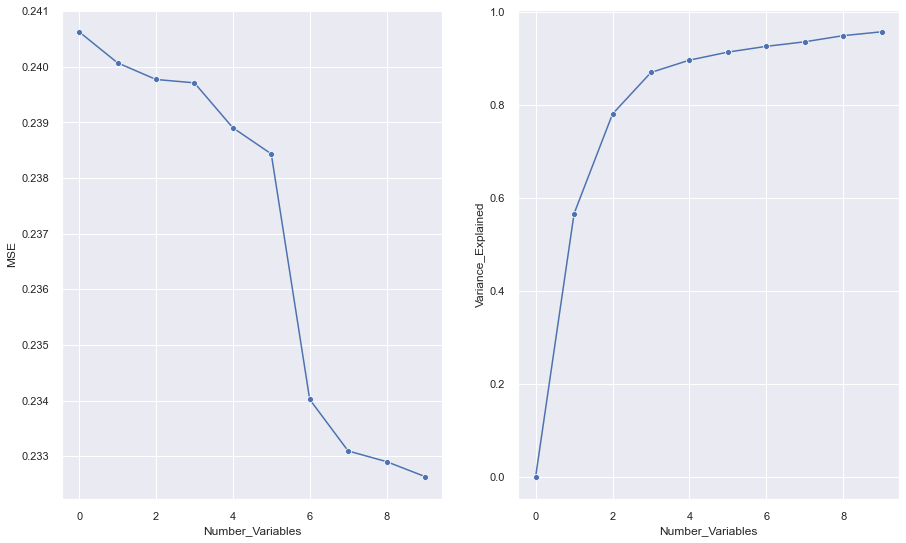

In [285]:
# PCA Pre-Run on Complete Dataframe to Identify right Hyperparams
df = tempModelingDF
PCA_relevant_features = ['age_10yrStart','time_in_hospital','num_lab_procedures',
                    'num_medications','number_outpatient','number_emergency','number_inpatient',
                    'number_diagnoses','num_procedures','num_of_meds']
# parking lot: (empty)

PCA_ResponseVar = 'readmitted'

PCA_PreProcess_Elbow(df,PCA_relevant_features,PCA_ResponseVar)
plt.show()

In [286]:
# Call PCA Function for Test/Train Sets.  Also returns new Predictor Var list for use in later models

features = PCA_relevant_features
PCs = 4

x_train, PredictorVar = PCA_Actual(x_train,features,PCs) # set, features for PCA, number of P.Cs
x_test, PredictorVar = PCA_Actual(x_test,features,PCs) # set, features for PCA, number of P.Cs

## Random Forest

In [287]:
print("starting RF")
# Random Forest
## Set and Fit Model
rndClf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16,n_jobs=-1)
rndClf.fit(x_train,y_train)

## Make Predictions
y_pred = rndClf.predict(x_test)
print("done RF")

starting RF
done RF


start plot


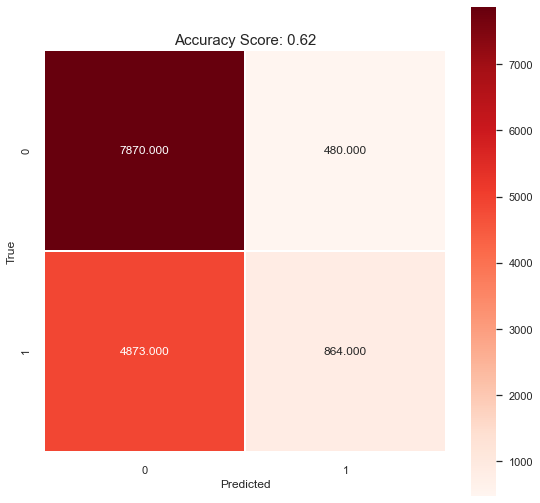

In [288]:
print("start plot")
# Random Forest -- Plot CM
regObj = rndClf # update mode
cm_y_test = y_test
cm_y_pred = y_pred # Update yPred
cm_x_test = x_test

cm, score = createConfMatrix(regObj,cm_y_test, cm_y_pred, cm_x_test)

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);


In [289]:
# Random Forest -- Precision/Recall Scores
print("Start Score Calc")

## Set Params
scores_y_test = y_test
scores_y_pred = y_pred # Update yPred

## Call Function
precision, recall, f1 = precisionRecall(scores_y_test, scores_y_pred)

## Print
print(f"Precision:",precision)
print(f"Recall:",recall)
print(f"F1:",f1)

Start Score Calc
Precision: 0.6429
Recall: 0.1506
F1: 0.244


Start ROC Plot


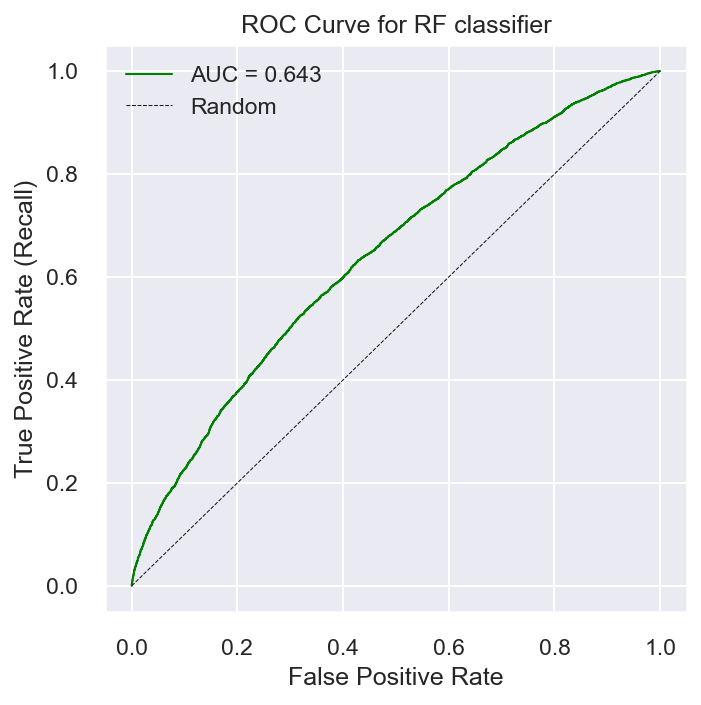

In [290]:
# ROC Curve/ AUC Score
print("Start ROC Plot")
## Set Params
model = rndClf
roc_x_test = x_test
roc_y_test = y_test # Update yPred

## Call Function
ROC_Curve_Plot(model,roc_x_test, roc_y_test)
plt.show()

Start Feature Importance


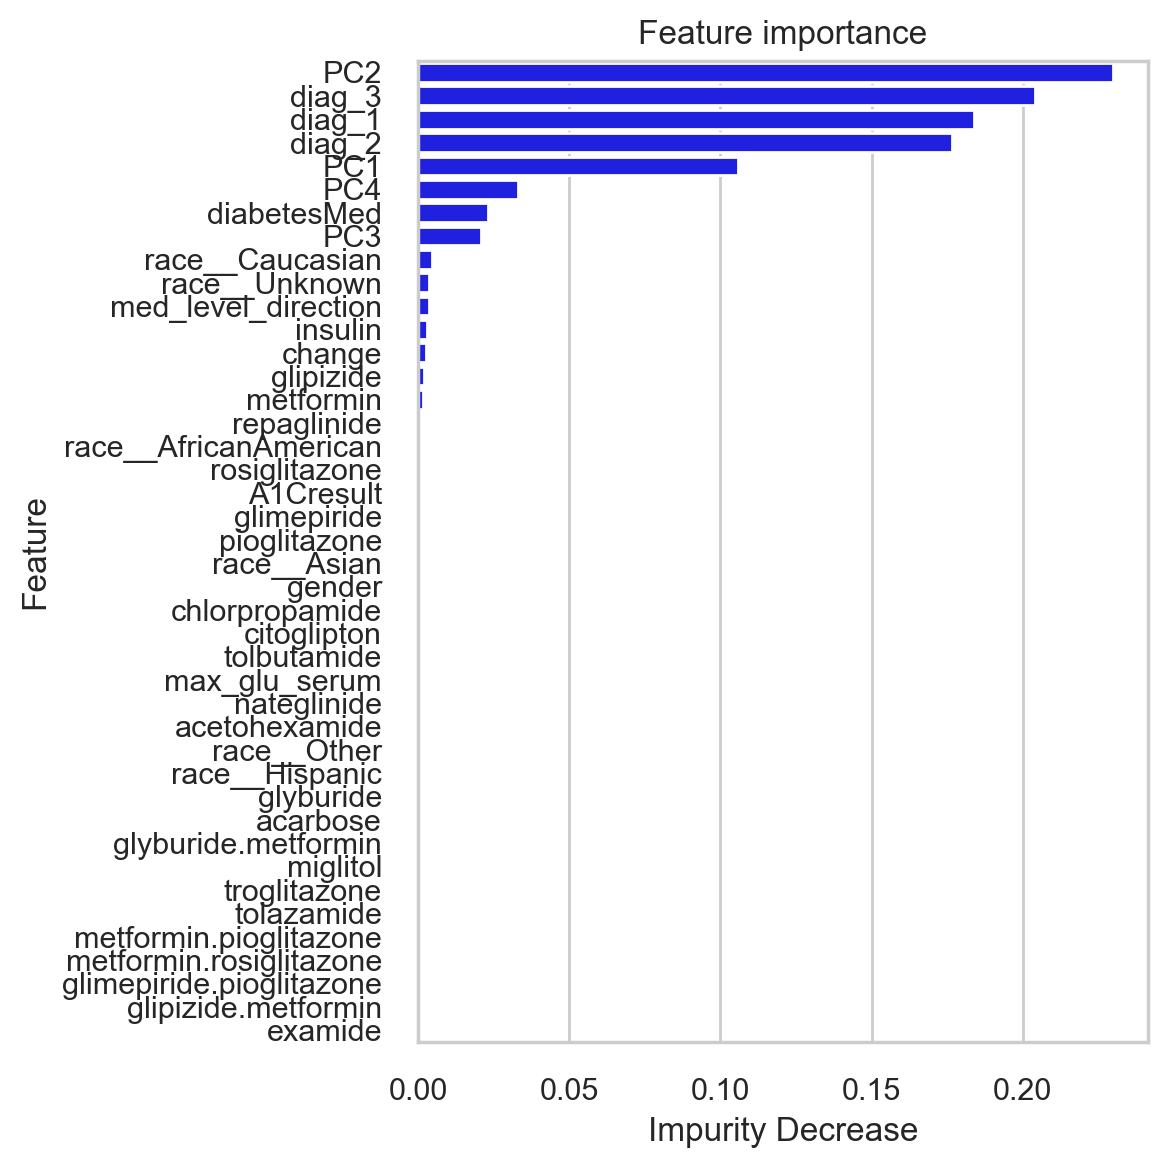

In [291]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start Feature Importance")
feature_importances, fig = FeatureImportance(rndClf)
fig.show()

## Gradient Boosting

## Neural Network

## K-Means Clustering

In [292]:
# Make a copy of the DF
k_means_df = tempModelingDF
k_means_df = k_means_df.drop(columns=['readmitted'])


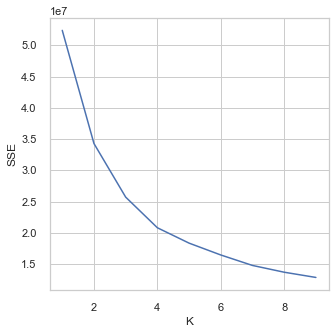

In [293]:
# Call Elbow Plot Function
KMeansElbowPlot(k_means_df)
plt.show()

In [294]:
# K-Means - set number of clusters based on elbow
km = KMeans(n_clusters=4)
km

KMeans(n_clusters=4)

In [295]:
# Scale Data using min max scaler

scaler = MinMaxScaler()
colNames = k_means_df.columns.values.tolist()

for column in k_means_df[colNames]:
    scaler.fit(k_means_df[[column]])
    k_means_df[column] = scaler.transform(k_means_df[[column]])

k_means_df.head()

,gender,age_10yrStart,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,change,diabetesMed,num_of_meds,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown
0,0.0,0.555556,0.538462,0.580153,1.000000,0.4000,0.0,0.0,0.0,0.469278,...,1.0,1.0,0.500000,0.333333,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.444444,0.076923,0.374046,0.833333,0.1500,0.0,0.0,0.0,0.497885,...,0.0,1.0,0.166667,0.500000,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.777778,0.846154,0.351145,0.333333,0.2125,0.0,0.0,0.0,0.437740,...,1.0,1.0,0.333333,0.333333,0.0,0.0,1.0,0.0,0.0,0.0
3,0.5,0.666667,0.538462,0.427481,1.000000,0.3750,0.0,0.0,0.0,0.407571,...,0.0,1.0,0.166667,0.500000,0.0,0.0,1.0,0.0,0.0,0.0
4,0.5,0.888889,0.076923,0.282443,0.000000,0.0875,0.0,0.0,0.0,0.578628,...,0.0,1.0,0.166667,0.500000,0.0,0.0,1.0,0.0,0.0,0.0


In [296]:
# Re-Train Dataset using Scaled Data
y_predicted = km.fit_predict(k_means_df[colNames])
k_means_df['Cluster'] = y_predicted
k_means_df['Cluster'].value_counts(dropna=False)

3    25928
0    17977
2    13836
1    12692
Name: Cluster, dtype: int64

In [297]:
# Show Centroid Clusters
clusters = km.cluster_centers_
clusters

array([[ 2.41363965e-01,  6.89776443e-01,  2.32044364e-01,
         3.08722299e-01,  2.37395932e-01,  1.71422512e-01,
         7.30298238e-03,  2.29261199e-03,  1.69012256e-02,
         4.35912775e-01,  4.15538209e-01,  4.16500893e-01,
         4.13980827e-01,  1.57979641e-02,  8.82516549e-02,
         9.93491684e-02,  6.67519608e-03,  3.04092266e-03,
         1.59463018e-03,  2.79616547e-02,  4.30292737e-19,
         7.85818917e-02,  6.74565649e-02,  6.11892974e-04,
         2.94079472e-02,  2.29923421e-02,  7.78772876e-04,
         1.11253268e-04, -1.44334414e-18,  8.34399510e-04,
         0.00000000e+00,  0.00000000e+00,  3.23301997e-01,
         4.37596188e-03,  1.11253268e-04,  0.00000000e+00,
         8.60585474e-19,  4.30292737e-19,  1.18238752e-14,
         1.00000000e+00,  1.66666667e-01,  5.00000000e-01,
        -8.43769499e-15,  9.23402125e-03,  9.13723091e-01,
         2.35856928e-02,  1.78005229e-02,  3.56566724e-02],
       [ 1.96028995e-01,  6.13859999e-01,  2.57418362e-

In [298]:
#Merge clusters ("Temp") back with the preserved original DF
tempModelingDF = pd.merge(tempModelingDF, k_means_df[['Cluster']], left_index=True, right_index=True)
tempModelingDF.head()

,gender,age_10yrStart,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,num_of_meds,med_level_direction,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted,Cluster
0,0,50,8,77,6,33,0,0,0,0.436000,...,3,-1,0,0,1,0,0,0,1,3
1,0,40,2,50,5,13,0,0,0,0.462579,...,1,0,0,0,1,0,0,0,1,0
2,0,70,12,47,2,18,0,0,0,0.406699,...,2,-1,0,0,1,0,0,0,0,3
3,1,60,8,57,6,31,0,0,0,0.378669,...,1,0,0,0,1,0,0,0,0,0
4,1,80,2,38,0,8,0,0,0,0.537596,...,1,0,0,0,1,0,0,0,0,0


No handles with labels found to put in legend.


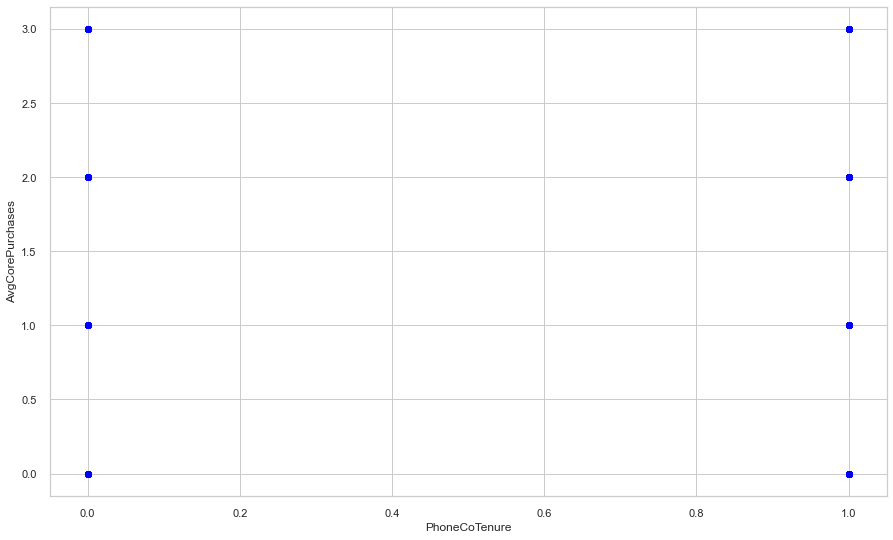

In [299]:
# TODO -- Need to refactor, useless right now.

# Replot on scatterplot using scaled data -- Include Centroid Clusters
# Set each cluster as a dataframe
cluster0 = tempModelingDF[tempModelingDF['Cluster'] == 0]
cluster1 = tempModelingDF[tempModelingDF['Cluster'] == 1]
cluster2 = tempModelingDF[tempModelingDF['Cluster'] == 2]
cluster3 = tempModelingDF[tempModelingDF['Cluster'] == 3]

fig_dims = (15, 9)
fig, ax = plt.subplots(figsize=fig_dims)

plt.scatter(tempModelingDF['readmitted'],tempModelingDF['Cluster'], color='blue',alpha=0.2)
#plt.scatter(cluster1['readmitted'],cluster1['Cluster'], color='green',alpha=0.2)
#plt.scatter(cluster2['readmitted'],cluster2['Cluster'], color='yellow',alpha=0.2)
#plt.scatter(cluster3['readmitted'],cluster2['Cluster'], color='orange',alpha=0.2)
#plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='red',marker='*', label='centroid')

plt.xlabel('PhoneCoTenure')
plt.ylabel('AvgCorePurchases')
plt.legend()

#### Summary -- Describe Clusters

* Some ideas: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/

# Experimentation/ Scratchpad

In [300]:
expData.sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
31445,149480796,41723604,Caucasian,Male,[70-80),NaN,3,3,1,12,...,No,Down,No,No,No,No,No,Ch,Yes,>30
45270,361434206,69367419,AfricanAmerican,Male,[70-80),NaN,6,3,1,7,...,No,Steady,No,No,No,No,No,No,Yes,NO
30231,192274332,40969116,Caucasian,Male,[70-80),NaN,3,1,1,1,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
16707,5516124,22783734,NaN,Male,[50-60),NaN,2,1,4,5,...,No,Steady,No,No,No,No,No,No,Yes,<30
36534,207953004,51108120,AfricanAmerican,Female,[50-60),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,NO
17016,107774526,23198022,Caucasian,Male,[50-60),NaN,3,1,1,1,...,No,No,No,No,No,No,No,Ch,Yes,>30
69724,369586982,138778943,NaN,Female,[50-60),NaN,3,1,1,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
45303,316062854,69465024,Caucasian,Female,[70-80),NaN,1,22,7,3,...,No,No,No,No,No,No,No,No,Yes,<30
30977,184088454,41420592,Caucasian,Female,[80-90),NaN,3,1,1,8,...,No,Down,No,No,No,No,No,Ch,Yes,>30
22798,147783654,25184025,Caucasian,Male,[60-70),NaN,3,1,1,1,...,No,Steady,No,No,No,No,No,No,Yes,NO


In [301]:
#TODO - 1) Remove Response Vars from check 2) pull higher up probably in EDA

responseVar = 'readmitted'
corr = round(tempModelingDF.corr(),4)
corr = abs(corr[responseVar]).sort_values(ascending=False)

#Selecting highly correlated features
relevant_features = corr[corr>=0.04] # Look for Features w/ greater 0.05 cor
relevant_features

readmitted            1.0000
diag_1                0.1761
diag_2                0.1679
diag_3                0.1638
number_inpatient      0.1447
number_diagnoses      0.1076
number_emergency      0.0767
age_10yrStart         0.0718
number_outpatient     0.0651
diabetesMed           0.0617
time_in_hospital      0.0616
num_lab_procedures    0.0532
Name: readmitted, dtype: float64

In [302]:
#TEMP - Reduce to corrlated features.  If use this, then need to implement in a way that isn't manually keying in.
relevant_features_df = tempModelingDF[['readmitted','number_inpatient','number_emergency',
                                                      'age_10yrStart','number_outpatient','time_in_hospital',
                                                      'num_lab_procedures']]
relevant_features_df


,readmitted,number_inpatient,number_emergency,age_10yrStart,number_outpatient,time_in_hospital,num_lab_procedures
0,1,0,0,50,0,8,77
1,1,0,0,40,0,2,50
2,0,0,0,70,0,12,47
3,0,0,0,60,0,8,57
4,0,0,0,80,0,2,38
...,...,...,...,...,...,...,...
70428,0,0,0,50,0,6,61
70429,0,0,0,80,0,4,66
70430,0,0,0,80,0,2,45
70431,0,0,0,10,0,9,45


In [303]:
mainData['gender'].value_counts(dropna=False)

Female             38025
Male               33490
Unknown/Invalid        3
Name: gender, dtype: int64

In [304]:
expVars = ['num_of_meds','med_level_direction','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone','readmitted']

expSummaryVars = ['num_of_meds','med_level_direction','readmitted']

tempCor = mainData[expSummaryVars]
tempCor.sample(5)

KeyError: "['num_of_meds', 'med_level_direction'] not in index"

In [ ]:
#Multiple Regression -- Check Correlations in HeatMap
plt.figure(figsize=(12,10))
cor = round(tempCor.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [ ]:
#Multiple Regressions -- Correlation with output variable
responseVar = 'readmitted'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
#relevant_features = cor_target[cor_target>=0.01] # Look for Features w/ greater 0.05 cor
#relevant_features
cor_target

In [ ]:
mainData.shape

In [ ]:
mainData['max_glu_serum'].value_counts(dropna=False)